In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip -d ./

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np

In [37]:
from torch.utils.data import DataLoader, random_split
'''tinyimagenet_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the images to a consistent size
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize pixel values
])'''
tinyimagenet_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the images to a consistent size
    transforms.ToTensor()])

batch_size=16

tinyimagenet_root = './tiny-imagenet-200'
train_dataset = torchvision.datasets.ImageFolder(root=f'{tinyimagenet_root}/train',transform=tinyimagenet_transform)
test_dataset = torchvision.datasets.ImageFolder(root=f'{tinyimagenet_root}/test',transform=tinyimagenet_transform)
split_ratio=0.7
train_size = int(split_ratio*len(train_dataset))
validation_size = len(train_dataset) - (train_size )
print(f'Train size = {train_size}, Validation size = {validation_size}')

train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

Train size = 70000, Validation size = 30000


In [38]:
class Model(nn.Module):
  def __init__(self, latent_size=256, out_size=200):
    super().__init__()
    self.feature_extractor = models.resnet18(pretrained=True)

    # Replacing the last fully connected layer of resnet with a new one with the desired size
    num_features = self.feature_extractor.fc.in_features
    self.feature_extractor.fc = nn.Linear(num_features, latent_size)

    self.classifier = nn.Sequential(
        nn.Linear(latent_size, 256),
        nn.ReLU(),
        nn.Linear(256, out_size)
    )

    self.heatmap_generator = torch.nn.Sequential(
    torch.nn.Linear(latent_size, 512),
    torch.nn.BatchNorm1d(512),  # BatchNorm1d for 1D input
    torch.nn.ReLU(),
    
    torch.nn.Linear(512, 1024),
    torch.nn.BatchNorm1d(1024),
    torch.nn.ReLU(),
    
    torch.nn.Linear(1024, 2048),
    torch.nn.BatchNorm1d(2048),
    torch.nn.ReLU(),
    
    torch.nn.Linear(2048, 64*64)
)


  def forward(self, x):
    latent_vect = self.feature_extractor(x)
    output = self.classifier(latent_vect)
    heatmap = self.heatmap_generator(latent_vect)
    heatmap = heatmap.view(-1, 1, 64, 64)
    return latent_vect, output, heatmap


In [39]:
def show_image(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()
# Encourage diversity in heatmap
def diversity_loss(x):
    mean_activation = torch.mean(x, dim=(2, 3), keepdim=True)
    diversity_loss = torch.mean(torch.abs(x - mean_activation))
    return diversity_loss

In [40]:
def view_heatmaps(model, dataset, n_examples=3,device="cuda"):
    indices = np.random.choice(len(dataset), n_examples)
    indices=[1,2,3]
    for i in indices:
        img, label = dataset[i]
        img = img.to(device)
        latenet,output, heatmap = model(img.unsqueeze(0))
  
        heatmap=threshold_heatmap(heatmap)
        energy_map = heatmap.squeeze()*img
        print(heatmap)
        y_pred = torch.argmax(output, dim=1).detach().item()
        print(y_pred)
        #print(f'Predicted Label: {class_name[y_pred]}, Actual Label: {class_name[label]}')

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(img.cpu().permute(1, 2, 0))

        plt.subplot(1, 3, 2)
        plt.title('Heatmap')
        plt.imshow(heatmap.cpu().detach().squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title('Energy Map')
        plt.imshow(energy_map.cpu().detach().squeeze().permute(1, 2, 0))
        plt.show()

In [41]:


def threshold_heatmap(heatmap):
    
    shape = heatmap.shape

    heatmap = heatmap.view(heatmap.shape[0], -1)
    mins = heatmap.min(dim=1)[0].unsqueeze(1).unsqueeze(1).unsqueeze(1)
    maxs = heatmap.max(dim=1)[0].unsqueeze(1).unsqueeze(1).unsqueeze(1)
    heatmap = heatmap.view(shape)

    heatmap = (heatmap - mins) / (maxs - mins + 1e-10) # normalizing
    
    mean = torch.mean(heatmap, dim=(2,3), keepdim=True)
    #heatmap[heatmap < mean] = 0
    return heatmap



In [42]:
model = Model()


In [43]:
def train(model,train_dataset,validation_dataset,batch_size,N   = 25,load_checkpoint=False, checkpoint_path=None):
    
    
    if load_checkpoint:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer = torch.optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch = checkpoint['epoch']
        losses = checkpoint['losses']
    else:
        losses=[]
    optimizer = torch.optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
    for epoch in range(N):

        loss = 0
        loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        model.train()
        

        for i, (images, labels) in enumerate(loader):
            image_re = images.to('cuda')
            model=model.to('cuda')
            labels=labels.to("cuda")
            
            optimizer.zero_grad()
            latent_vect, output, heatmap_  = model(image_re)
            
            #print(torch.mean(heatmap_).item())
            heatmap=threshold_heatmap(heatmap_)
            had_prod=image_re*heatmap
            #print("hi {} {}".format(i,heatmap.size()))
            latent_vect_hm, output_hm, heatmap_hm  = model(had_prod)
            #print("hi 2{}".format(i))
            L = nn.CrossEntropyLoss()
            #print(output.size(),labels.size(),labels[i],output[i])
            M=nn.MSELoss()
            L1=nn.L1Loss()
            # Sum the variances along the elements (columns)
            train_loss     =  L(output,labels)+L(output_hm,labels)+M(output,output_hm)+L1(heatmap,torch.zeros_like(heatmap))-diversity_loss(heatmap)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()
        
        correct_count = 0
        print('Entering eval loop...')
        model.eval()
        validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
        if epoch==0:
            view_heatmaps(model, validation_dataset, n_examples=3)

        for i, (images, labels) in enumerate(validation_loader):
            latent_vec,output, heatmap = model(images.to("cuda"))
            _, y_pred = torch.max(output, dim=1)
            correct_count += torch.sum(y_pred == labels.to("cuda"))        # Storing the model every epochs
        if checkpoint_path is None:
            checkpoint_path = f"checkpoint_{datetime.now().strftime('%d-%m-%y:%H-%M-%S')}.pt"
        print(f'Storing checkpoint at {checkpoint_path}')
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'losses': losses,
        }
        torch.save(checkpoint, checkpoint_path)

        losses.append(loss / len(loader))
        print(f'epoch : {epoch+1}/{N}, loss = {losses[-1]:.6f}, accuracy = {correct_count/len(validation_dataset)}')

    return losses

Entering eval loop...
tensor([[[[0.1530, 0.1465, 0.1644,  ..., 0.1485, 0.1866, 0.1810],
          [0.1797, 0.1877, 0.1276,  ..., 0.1671, 0.1526, 0.1773],
          [0.1769, 0.1851, 0.1685,  ..., 0.1494, 0.1833, 0.1675],
          ...,
          [0.1772, 0.1578, 0.1711,  ..., 0.1743, 0.1640, 0.1766],
          [0.1782, 0.1713, 0.1587,  ..., 0.1782, 0.1603, 0.1593],
          [0.1838, 0.1803, 0.2069,  ..., 0.1691, 0.1766, 0.1733]]]],
       device='cuda:0', grad_fn=<DivBackward0>)
136


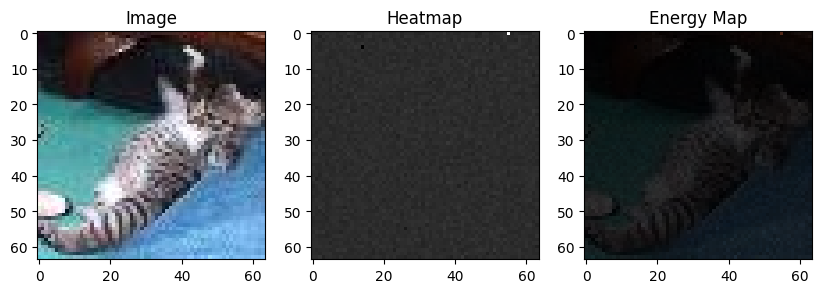

tensor([[[[0.1743, 0.1720, 0.1798,  ..., 0.1817, 0.1925, 0.1909],
          [0.1882, 0.1913, 0.1890,  ..., 0.1947, 0.1955, 0.2033],
          [0.2138, 0.2022, 0.1566,  ..., 0.1697, 0.1903, 0.2030],
          ...,
          [0.1891, 0.2042, 0.1985,  ..., 0.1802, 0.1991, 0.2110],
          [0.2151, 0.1832, 0.1816,  ..., 0.2063, 0.1757, 0.2090],
          [0.1849, 0.1856, 0.1975,  ..., 0.1767, 0.1809, 0.1979]]]],
       device='cuda:0', grad_fn=<DivBackward0>)
153


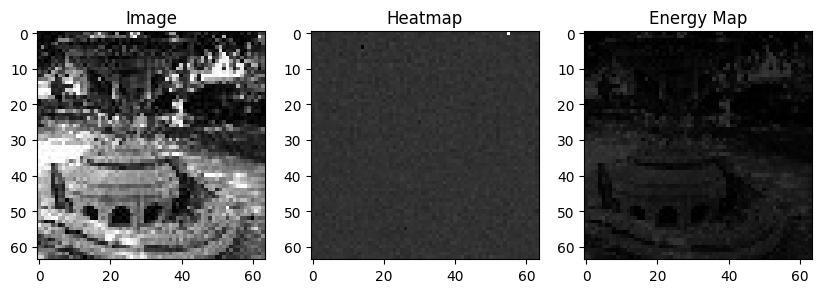

tensor([[[[0.1931, 0.1860, 0.2008,  ..., 0.1913, 0.2017, 0.2176],
          [0.2063, 0.2003, 0.1796,  ..., 0.1910, 0.1641, 0.2272],
          [0.2080, 0.2108, 0.1943,  ..., 0.1836, 0.2137, 0.1898],
          ...,
          [0.1965, 0.1862, 0.1916,  ..., 0.1884, 0.1772, 0.1986],
          [0.2165, 0.1949, 0.1908,  ..., 0.1969, 0.1721, 0.1906],
          [0.1820, 0.2192, 0.2215,  ..., 0.2096, 0.2045, 0.2004]]]],
       device='cuda:0', grad_fn=<DivBackward0>)
168


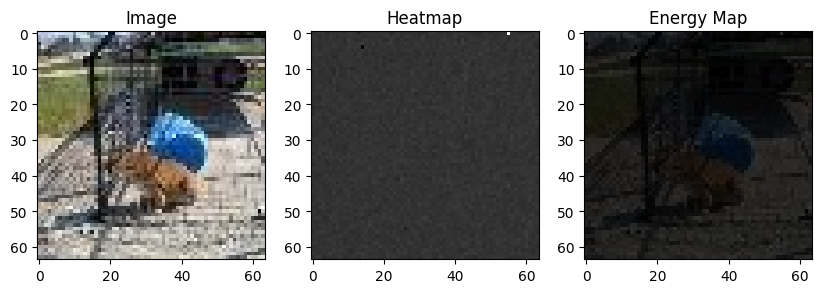

Storing checkpoint at /kaggle/working/checkpoint_18-11-23:06-50-31.pt
epoch : 1/10, loss = 9.388607, accuracy = 0.1995999962091446
Entering eval loop...
Storing checkpoint at /kaggle/working/checkpoint_18-11-23:06-50-31.pt
epoch : 2/10, loss = 5.760810, accuracy = 0.34066668152809143
Entering eval loop...
Storing checkpoint at /kaggle/working/checkpoint_18-11-23:06-50-31.pt
epoch : 3/10, loss = 4.325766, accuracy = 0.35296666622161865


In [ ]:

from datetime import datetime
path="/kaggle/working/checkpoint_18-11-23:06-50-31.pt"
train(model,train_dataset,validation_dataset,100,N   = 10,load_checkpoint=False, checkpoint_path=path)
'''
for i, (images, labels) in enumerate(train_loader):
  latent_vector, output, heatmaps = model(images)
  # print(images.size())
  # print(heatmap.size())
  # print(labels.size())
  # print(torch.argmax(output[0]).size())
  for j in range(images.size()[0]):
    img = images[j]
    y_true = labels[j]
    y_pred = torch.argmax(output[j])
    heatmap = heatmaps[j]
    print(y_true.item(), y_pred.item())
    show_image(img.permute(1, 2, 0))
    plt.imshow(heatmap.permute(1, 2, 0).detach().numpy())
    if j == 2:
      break

  if i == 0:
    break'''

In [ ]:
view_heatmaps(model, validation_dataset, n_examples=3)

In [ ]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model'])
view_heatmaps(model, validation_dataset, n_examples=3)

In [ ]:
tensor_to_normalize = torch.rand(1, 1, 64, 64)

# Reshape to (1, 64, 64) for normalization
reshaped_tensor = tensor_to_normalize.view(1, -1)

# Normalize across all dimensions
normalized_tensor = nn.functional.normalize(reshaped_tensor, p=2, dim=-1)

# Reshape back to the original shape
normalized_tensor = normalized_tensor.view(1, 1, 64, 64)

print("Original Tensor:")
print(tensor_to_normalize,tensor_to_normalize.max())
print(normalized_tensor,normalized_tensor.max())